# Single-cell RNA-seq analysis workflow using Scanpy on CPU

Copyright (c) 2020, NVIDIA CORPORATION.  All rights reserved.

NVIDIA CORPORATION and its licensors retain all intellectual property
and proprietary rights in and to this software, related documentation
and any modifications thereto.  Any use, reproduction, disclosure or
distribution of this software and related documentation without an express
license agreement from NVIDIA CORPORATION is strictly prohibited.

## Import requirements

In [1]:
import numpy as np
import scanpy as sc
from timeit import default_timer as timer
import pandas as pd
import time
import sys
import os
from sklearn.cluster import KMeans

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


## Set parameters

In [2]:
# marker genes
RIBO_GENE_PREFIX = "RPS" # Prefix for ribosomal genes to regress out
markers = ["ACE2", "TMPRSS2", "EPCAM"] # Marker genes for visualization

# filtering cells
min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed 

# filtering genes
n_top_genes = 5000 # Number of highly variable genes to retain

# PCA
n_components = 50 # Number of principal components to compute

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# k-means
k = 20 # Number of clusters for k-means

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

# Louvain
louvain_resolution = 0.4

# Gene ranking
ranking_n_top_genes = 50 # Number of differential genes to compute for each cluster

# Number of parallel jobs for t-SNE and k-means
n_jobs=32

In [3]:
start = time.time()

## Load and Prepare Data

In [4]:
# Add path to input file here.
input_file = "krasnow_hlca_10x_UMIs.sparse.h5ad"

In [5]:
%%time
adata = sc.read(input_file)
adata = adata.T

CPU times: user 4.98 s, sys: 969 ms, total: 5.95 s
Wall time: 5.96 s


## Preprocessing

In [6]:
preprocess_start = time.time()

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.

In [7]:
%%time
sc.pp.filter_cells(adata, min_genes=min_genes_per_cell)
sc.pp.filter_cells(adata, max_genes=max_genes_per_cell)
adata.shape

CPU times: user 1.9 s, sys: 1.82 s, total: 3.71 s
Wall time: 3.71 s


(65462, 26485)

Some genes will now have zero expression in all cells. We filter out such genes.

In [8]:
%%time
sc.pp.filter_genes(adata, min_cells=1)

CPU times: user 1.46 s, sys: 907 ms, total: 2.36 s
Wall time: 2.36 s


### Normalize

In [9]:
%%time
sc.pp.normalize_total(adata, target_sum=1e4)

CPU times: user 608 ms, sys: 128 ms, total: 737 ms
Wall time: 734 ms


In [10]:
%%time
sc.pp.log1p(adata)

CPU times: user 1.9 s, sys: 0 ns, total: 1.9 s
Wall time: 1.9 s


### Select Most Variable Genes

In [11]:
%%time
# Filter matrix to only variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor="cell_ranger")

# Retain marker gene expression
for marker in markers:
    adata.obs[marker+"_raw"]= adata.X[:, adata.var.index==marker].todense()

adata = adata.copy()
n_genes = sum(adata.var.highly_variable)
print("Selected " + str(n_genes) + " genes.")
adata = adata[:, adata.var.highly_variable]

Selected 5000 genes.
CPU times: user 3.45 s, sys: 291 ms, total: 3.75 s
Wall time: 3.75 s


### Regress out confounding factors (number of counts, ribosomal gene expression)

In [12]:
ribo_genes = adata.var_names.str.startswith(RIBO_GENE_PREFIX)

In [13]:
%%time
n_counts = np.array(adata.X.sum(axis=1))
adata.obs['percent_ribo'] = np.array(np.sum(adata[:, ribo_genes].X, axis=1)) / n_counts
adata.obs['n_counts'] = n_counts

Trying to set attribute `.obs` of view, copying.


CPU times: user 1.47 s, sys: 205 ms, total: 1.68 s
Wall time: 1.67 s


In [14]:
sc.pp.regress_out(adata, ['n_counts', 'percent_ribo'])

### Scale

In [15]:
%%time
sc.pp.scale(adata, max_value=10)

CPU times: user 3.46 s, sys: 242 ms, total: 3.7 s
Wall time: 3.7 s


In [16]:
preprocess_time = time.time()
print("Total Preprocess time (includes data load): %s" % (preprocess_time-preprocess_start))

Total Preprocess time (includes data load): 937.2924320697784


## Cluster & Visualize

In [17]:
cluster_start = time.time()

### Reduce

In [18]:
%%time
# PCA
sc.tl.pca(adata, n_comps=n_components)

CPU times: user 8min 3s, sys: 3min 21s, total: 11min 25s
Wall time: 25.6 s


### TSNE + K-means

In [19]:
%%time
sc.tl.tsne(adata, n_pcs=tsne_n_pcs, n_jobs=n_jobs)

CPU times: user 1h 17min 16s, sys: 0 ns, total: 1h 17min 16s
Wall time: 3min 18s


In [20]:
%%time
kmeans = KMeans(n_clusters=k, random_state=0, n_jobs=n_jobs).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = kmeans.labels_.astype(str)

CPU times: user 5.01 s, sys: 0 ns, total: 5.01 s
Wall time: 3.5 s


In [21]:
%%time
sc.pl.tsne(adata, color=["kmeans"])

... storing 'kmeans' as categorical


CPU times: user 5.79 s, sys: 0 ns, total: 5.79 s
Wall time: 672 ms


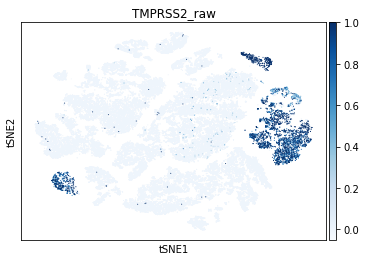

CPU times: user 1.8 s, sys: 0 ns, total: 1.8 s
Wall time: 1.05 s


In [22]:
%%time
sc.pl.tsne(adata, size=4, color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, size=4, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, size=4, color=["EPCAM_raw"], color_map="Reds", vmax=1,  vmin=-0.05)

### UMAP + Louvain

In [23]:
%%time
# KNN graph
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)

CPU times: user 25.2 s, sys: 0 ns, total: 25.2 s
Wall time: 25.1 s


In [24]:
%%time
# UMAP
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)

CPU times: user 7min 22s, sys: 12min 36s, total: 19min 58s
Wall time: 2min 3s


In [25]:
%%time
# Louvain clustering
sc.tl.louvain(adata, resolution=louvain_resolution)

CPU times: user 10.9 s, sys: 0 ns, total: 10.9 s
Wall time: 10.9 s


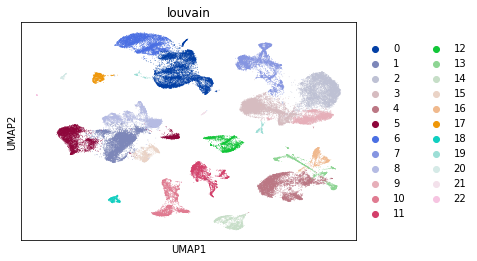

CPU times: user 650 ms, sys: 165 ms, total: 816 ms
Wall time: 563 ms


In [26]:
%%time
# Plot
sc.pl.umap(adata, color=["louvain"])

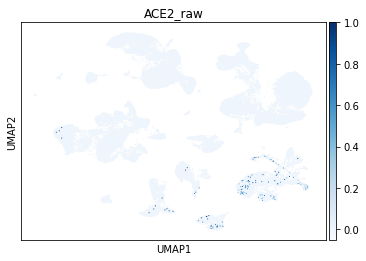

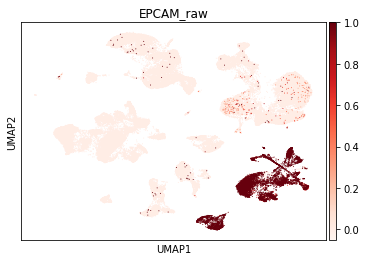

CPU times: user 1.33 s, sys: 563 ms, total: 1.89 s
Wall time: 1.15 s


In [27]:
%%time
sc.pl.umap(adata, size=4,color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, size=4, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, size=4, color=["EPCAM_raw"], color_map="Reds", vmax=1, vmin=-0.05)

In [28]:
cluster_time = time.time()
print("Total cluster time : %s" % (cluster_time-cluster_start))

Total cluster time : 390.75470328330994


## Differential expression analysis

In [29]:
%%time
sc.tl.rank_genes_groups(adata, groupby="louvain", n_genes=ranking_n_top_genes, groups='all', reference='rest')

/usr/local/lib/python3.6/dist-packages/scanpy/tools/_rank_genes_groups.py:252: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


CPU times: user 46.4 s, sys: 12.7 s, total: 59.1 s
Wall time: 59.1 s


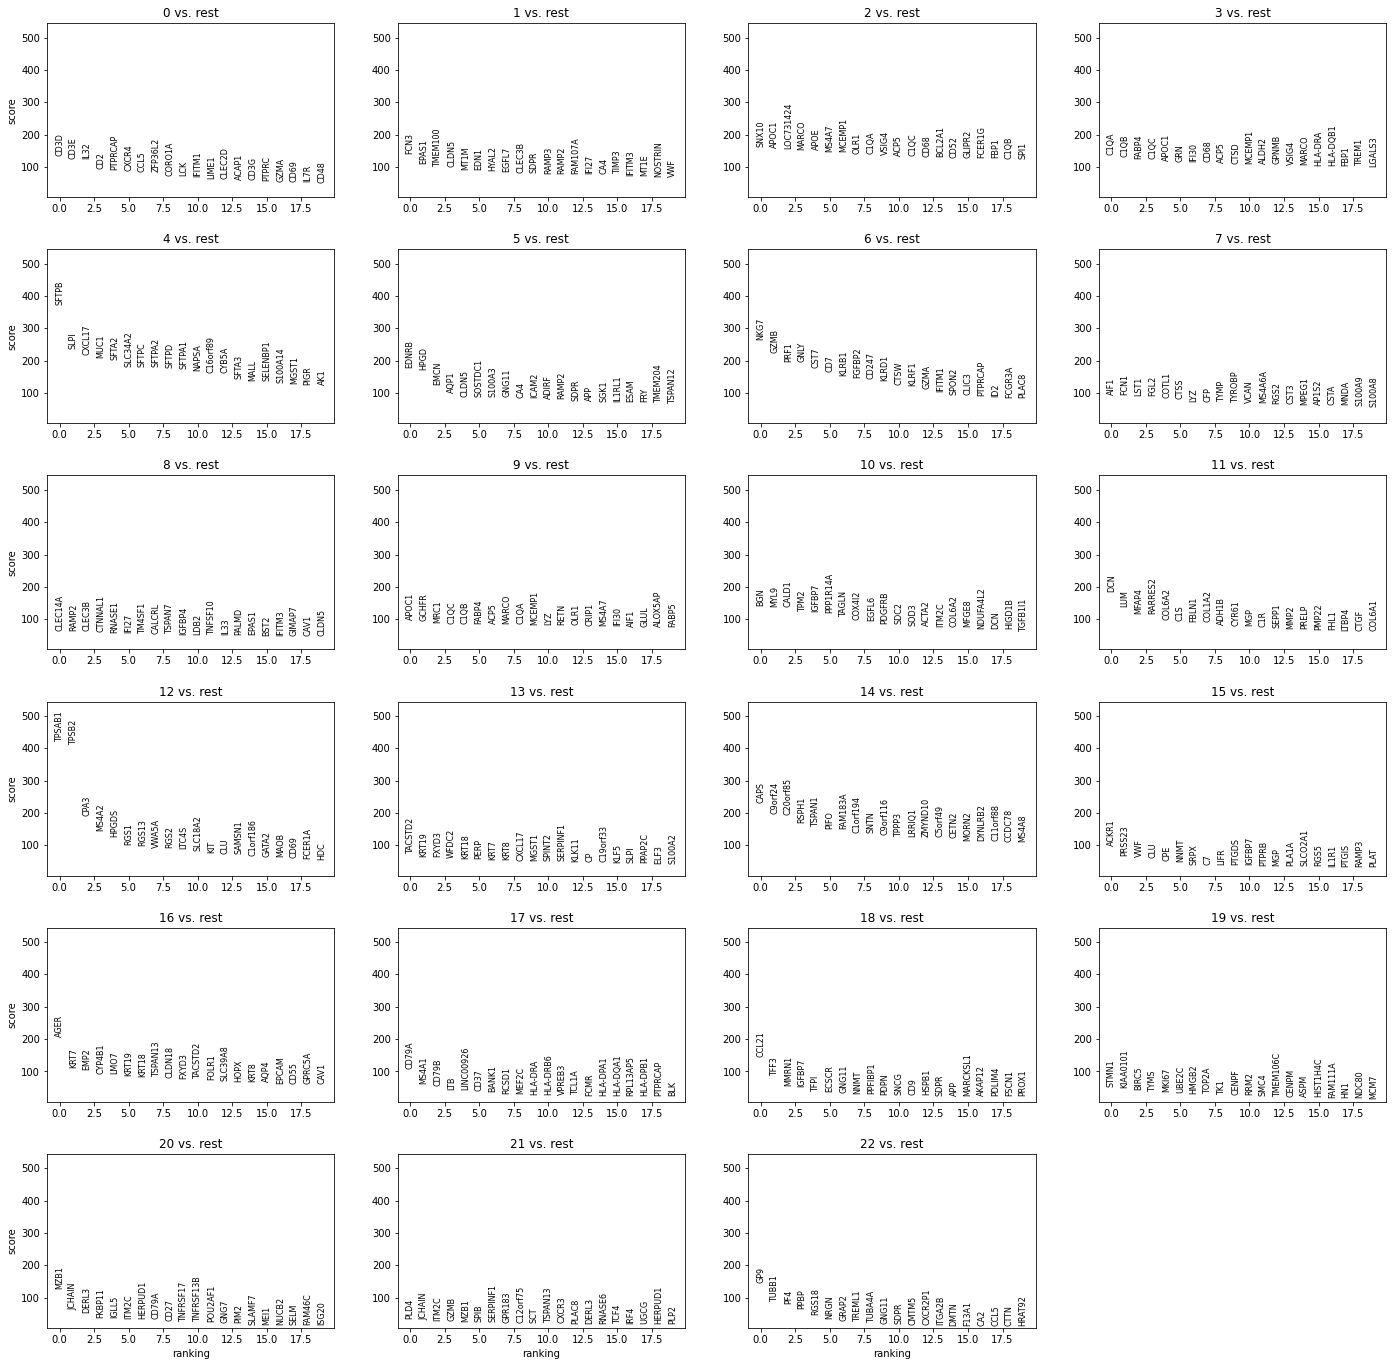

CPU times: user 4.47 s, sys: 125 ms, total: 4.6 s
Wall time: 4.59 s


In [30]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

In [31]:
total_time = time.time() - start

## Create zoomed-in view

In [32]:
reanalysis_start = time.time()

In [33]:
%%time

adata = adata[adata.obs["EPCAM_raw"] > 0.0, :]
print(adata.X.shape)

(7958, 5000)
CPU times: user 256 ms, sys: 75.8 ms, total: 332 ms
Wall time: 330 ms


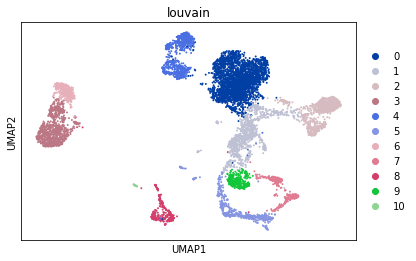

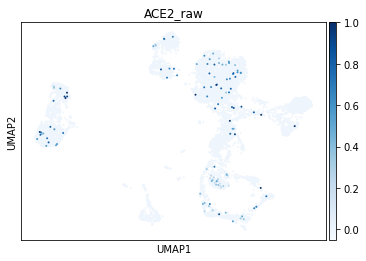

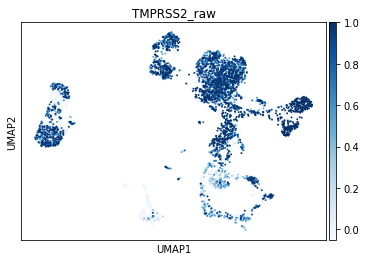

CPU times: user 1min 47s, sys: 2min 22s, total: 4min 10s
Wall time: 32 s


In [34]:
%%time
sc.tl.pca(adata, n_comps=n_components)
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)
sc.tl.louvain(adata, resolution=louvain_resolution)

sc.pl.umap(adata, color=["louvain"])
sc.pl.umap(adata, color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)

In [35]:
reanalysis_time = time.time()
print("Total reanalysis time : %s" % (reanalysis_time-reanalysis_start))

Total reanalysis time : 32.34500861167908


In [36]:
print("Full time: %s" % (time.time() - start))

Full time: 1430.0828895568848
